In [30]:
import numpy as np
import matplotlib.pyplot as plt
import emcee, corner, fsps
from cgs import *

%matplotlib inline

In [194]:
name,ra,dec,dist,mb,mberr,morph,EBV,FUV,FUVerr,NUV,NUVerr = [],[],[],[],[],[],[],[],[],[],[],[]
with open('ps5.txt','r') as f:
    for i,line in enumerate(f):
        if i == 0:
            next(f)
        else:
            l = line.split()
            l = [val.strip(', \n') for val in l]
            name.append(l[0])
            ra.append(l[1]+' '+l[2]+' '+l[3])
            dec.append(l[4]+' '+l[5]+' '+l[6])
            dist.append(float(l[7]))
            mb.append(float(l[8]))
            mberr.append(np.abs(np.random.normal(0,0.1)))
            morph.append(int(l[9]))
            EBV.append(float(l[10]))
            FUV.append(float(l[11]))
            FUVerr.append(float(l[12]))
            NUV.append(float(l[13]))
            NUVerr.append(float(l[14]))
        

In [253]:
FUV = np.asarray(FUV)
FUVerr = np.asarray(FUVerr)
mb = np.asarray(mb)
dist = np.asarray(dist)

# Problem 1

In [209]:
sp = fsps.StellarPopulation(imf_type = 2, zcontinuous = 1, logzsol = 0, sfh = 1, const = 1)

In [210]:
fsps.find_filter('uv')

['wfc3_uvis_f218w',
 'wfc3_uvis_f814w',
 'wfc3_uvis_f438w',
 'uvot_m2',
 'wfc3_uvis_f390w',
 'wfc3_uvis_f336w',
 'uvot_w2',
 'wfc3_uvis_f606w',
 'wfc3_uvis_f775w',
 'wfc3_uvis_f475w',
 'wfc3_uvis_f850lp',
 'wfc3_uvis_f225w',
 'galex_nuv',
 'galex_fuv',
 'uvot_w1',
 'wfc3_uvis_f555w',
 'wfc3_uvis_f275w']

In [211]:
fuv_sp = float(sp.get_mags(bands=['galex_fuv'],tage=13.7))
sfr_sp = float(sp.sfr)
print(fuv_sp,sfr_sp)

(6.846419917105074, 7.299270072992702e-11)


In [212]:
#find effective wavelength
wl = fsps.filters.get_filter('galex_fuv').lambda_eff #in angstroms
nu = c/(wl*1e-8) #in Hz
lognu = np.log10(nu)
print(lognu)

15.290984583


In [213]:
f0 = 3631e-23
M0 = -2.5*np.log10(f0)

f_nu = f0*10**(-0.4*fuv_sp)
d = 10*pc
L_nu = 4*np.pi*d**2*f_nu
logL = np.log10(L_nu)

In [214]:
Cfuv = lognu + logL - np.log10(sfr_sp)
print('The value of Cfuv I get is '+str(Cfuv))

The value of Cfuv I get is 43.3271651397


This is nearly exactly equal to the value in Kennicutt.  My result is smaller than his by a factor of 0.02 dex.  They could be slightly different because the Kennicutt result uses a different stellar model (starburst99) whereas we use the MIST models.

# Problem 2

In [215]:
b_sp = float(sp.get_mags(bands=['b'],tage=13.7))

In [216]:
print(b_sp)

5.75400372537


Since FSPS outputs one solar mass in total of stars, this B-band magnitude is already normalized to per-solar-mass units.  So we can convert between mass and B-band magnitude using the following:
\begin{equation}
M/M_\odot = M_B / 5.754
\end{equation}

The B-band is not that good a place to estimate stellar masses because (1) you aren't as sensitive to old, low-mass stars, (2) you're affected fairly strongly by extinction, and (3) the mass you get out depends on stellar models, which may be somewhat uncertain.

# Problem 3

In [217]:
def abs_mag(m,d):
    # d must be in parsecs
    return m - 5*(np.log10(d) - 1)

In [222]:
dist_red = dist[np.where(mb <= 99.0)]
mb_red = mb[np.where(mb <= 99.0)]
Mb_red = abs_mag(mb_red,dist_red*1.0e6)

Berg et al. (2012) give the relationship
\begin{equation}
12 + \log (\textrm{O}/\textrm{H}) = (6.27 \pm 0.21) + (-0.11 \pm 0.01) M_B
\end{equation}

In [226]:
z_red = 6.27 - Mb_red*0.11

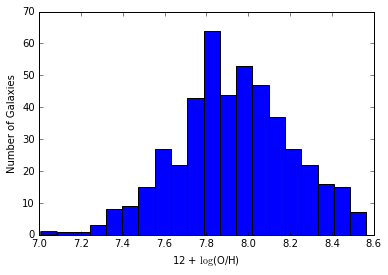

In [229]:
plt.hist(z_red,bins=20)
plt.ylabel(r'Number of Galaxies')
plt.xlabel(r'12 + $\log$(O/H)')
plt.show()

# Problem 4

In [273]:
#get a full sample taking out bad M_b and FUV points
dist_u = dist[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
mb_u = mb[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
FUV_u = FUV[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
Mb_u = abs_mag(mb_u,dist_u*1.0e6)
z_u = 6.27 - Mb_u*0.11

In [274]:
#Determine SFR_FUV for the sample using the Kennicutt prescription
f_nu_u = f0*10**(-0.4*FUV_u)
L_nu_u = 4*np.pi*(dist_u*1e6*pc)**2*f_nu_u
logL_u = np.log10(L_nu_u)

logsfr_fuv = logL_u + lognu - Cfuv

In [284]:
#figure out the error
FUV_err = FUVerr[np.where(np.logical_and(mb <= 99.0,FUV <= 99.0,FUVerr <= 99.0))]
frac_err = FUV_err/FUV_u
frac_err[frac_err >= 1] = 0.01
logsfr_err = logsfr_fuv*frac_err

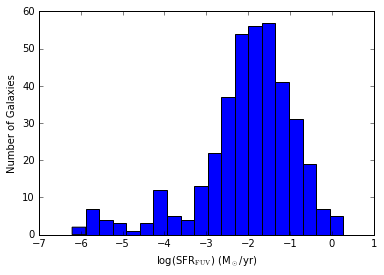

In [285]:
plt.hist(logsfr_fuv,bins=20)
plt.xlabel(r'log(SFR$_{\rm{FUV}}$) (M$_\odot$/yr)')
plt.ylabel('Number of Galaxies')
plt.show()

In [286]:
#determine M_star for the sample using the prescription from problem 2
Mstar_u = Mb_u/b_sp

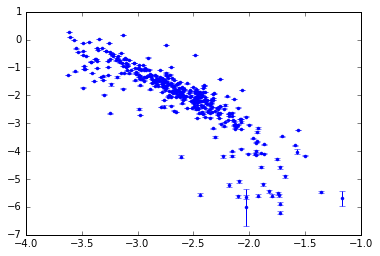

In [290]:
fig, ax = plt.subplots()
ax.errorbar(Mstar_u,logsfr_fuv,yerr=logsfr_err,linestyle='',marker='.')
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.show()

In [ ]:
# something is wrong here with the mass estimates... I think I didn't interpret #2 correctly.

In [306]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < -1.0 and -20.0 < b < 0.0 and -10.0 < lnf < 10.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

ndim, nwalkers = 3, 100
pos = [[-2.0,-10.0,0.0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Mstar_u, logsfr_fuv, logsfr_err))

In [307]:
sampler.run_mcmc(pos, 10000)

(array([[-1.44672408, -5.78799731, -1.03009742],
        [-1.40351148, -5.62574039, -0.98599731],
        [-1.38402971, -5.57563161, -1.02083087],
        [-1.30238407, -5.30673797, -0.94292358],
        [-1.38409965, -5.57748791, -1.00019415],
        [-1.40263806, -5.54882774, -0.93565111],
        [-1.40915872, -5.64891695, -1.07761314],
        [-1.40644892, -5.62772674, -0.90880975],
        [-1.37755468, -5.50479472, -0.90539367],
        [-1.34855777, -5.44890038, -1.01925778],
        [-1.35846432, -5.47693311, -0.97815053],
        [-1.43876519, -5.74739927, -1.03115238],
        [-1.37543643, -5.53053486, -0.97871558],
        [-1.32034603, -5.37378858, -0.96385552],
        [-1.4057525 , -5.65001717, -0.99506252],
        [-1.44118231, -5.73859092, -1.02924705],
        [-1.37984904, -5.51609826, -0.95117885],
        [-1.43747335, -5.75757451, -1.0070031 ],
        [-1.38643461, -5.55963871, -0.9449975 ],
        [-1.43888962, -5.74551096, -1.02723512],
        [-1.33427642

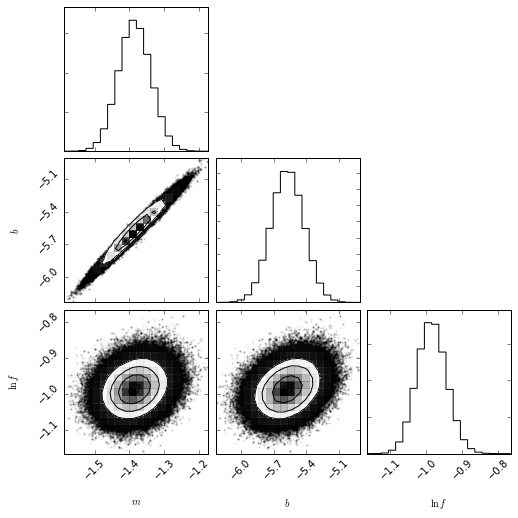

In [308]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"]) #truths=[m_true, b_true, np.log(f_true)])

In [315]:
nsamp = len(samples)
print(nsamp)

950000


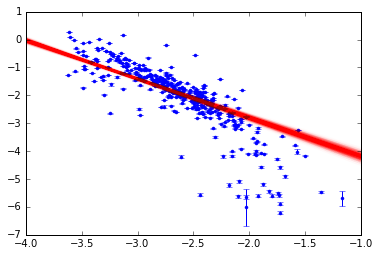

In [338]:
fig, ax = plt.subplots()
ax.errorbar(Mstar_u,logsfr_fuv,yerr=logsfr_err,linestyle='',marker='.')

xs = ax.get_xlim()

for j in range(1000):
    spl = samples[np.random.randint(0,nsamp)]
    thism = spl[0]
    thisb = spl[1]
    ax.plot([xs[0],xs[1]],[thism*xs[0]+thisb,thism*xs[1]+thisb],color='red',linestyle='-',alpha = 0.01)
   
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.show()

# Problem 5